In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('config.env'))

openai.api_key  = os.getenv('OPENAI_API_KEY')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [5]:
import pandas as pd
df = pd.read_csv('Data.csv')
df.head()

,ID,Product,Review
0,1,Quantum Processor,Excellent performance. Truly the future of com...
1,2,Azure Cloud Storage,Reliable and scalable. A game-changer for my b...
2,3,Neural Network Chip,Impressive speed and accuracy. AI at its best.
3,4,Quantum Encryption Module,Unbreakable security. Feels like magic!
4,5,Azure AI Services,Makes complex AI tasks a breeze. Highly recomm...


# LLMChain

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [7]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [8]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [9]:
chain = LLMChain(llm=llm, prompt=prompt)

In [12]:
product = "Queen Size Sheet Set"
chain.run(product)

'Royal Linens.'

# SimpleSequentialChain

In [13]:
from langchain.chains import SimpleSequentialChain

In [14]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [15]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [16]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [17]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
"Royal Sheets"
Royal Sheets is a bedding company offering luxurious, high-quality sheets made from premium materials for a comfortable and restful sleep experience.

> Finished chain.


'Royal Sheets is a bedding company offering luxurious, high-quality sheets made from premium materials for a comfortable and restful sleep experience.'

# SequentialChain

In [18]:
from langchain.chains import SequentialChain

Multiple inputs and outputs

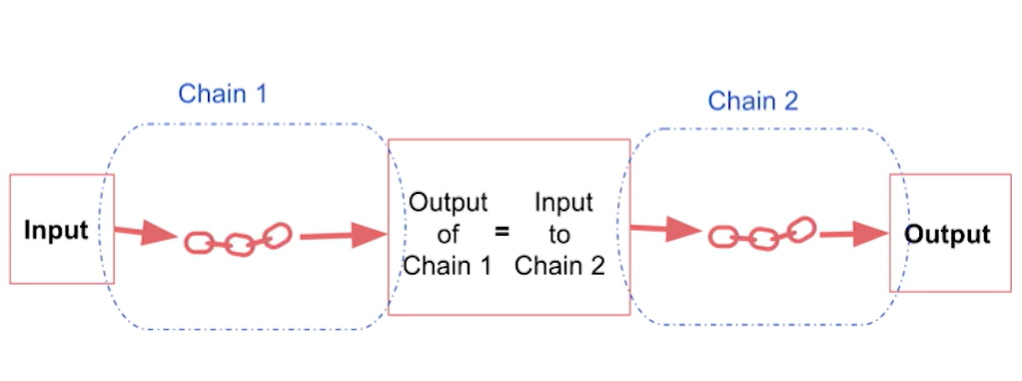

In [19]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )

In [20]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [21]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

In [22]:
# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

In [23]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [24]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': 'A must-have for quantum developers. Comprehensive and user-friendly.',
 'English_Review': 'Una herramienta imprescindible para desarrolladores cuánticos. Completa y fácil de usar.',
 'summary': 'An indispensable tool for quantum developers that is comprehensive and easy to use.',
 'followup_message': "Thank you for sharing this summary about the indispensable tool for quantum developers. It's great to hear that the tool is both comprehensive and easy to use, which will surely make quantum development much more accessible and efficient. With the ongoing advancements in quantum computing, having an effective tool that can help developers stay on top of the latest developments is crucial. I am excited to see what kind of progress this tool will enable in the quantum development space."}

# Router chain
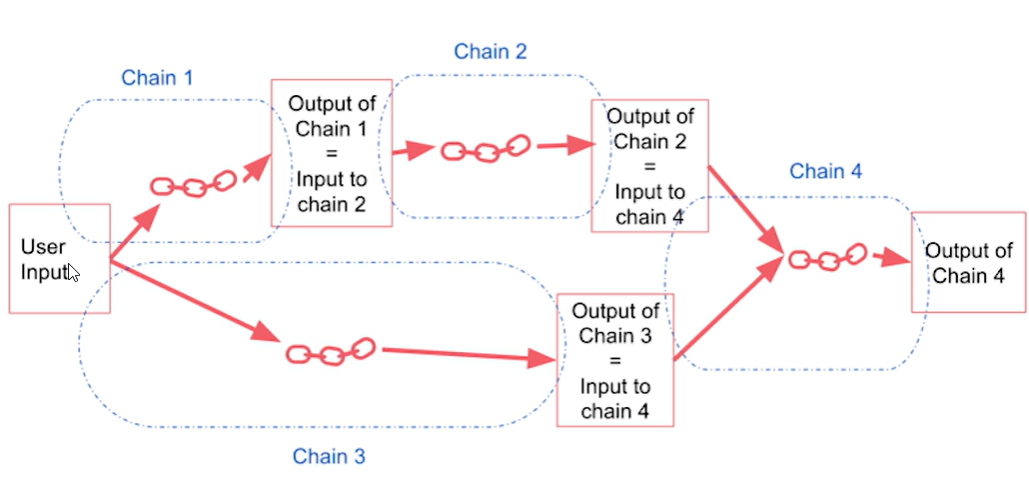

In [25]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [26]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [27]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [28]:
llm = ChatOpenAI(temperature=0, model=llm_model)

In [29]:

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [30]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [31]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [32]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [33]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [34]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the electromagnetic radiation emitted by a perfect black body, which is an object that absorbs all radiation that falls on it and emits radiation at all wavelengths. The radiation emitted by a black body depends only on its temperature and follows a specific distribution known as Planck's law. This type of radiation is important in understanding the behavior of stars, as well as in the development of technologies such as incandescent light bulbs and infrared cameras."

In [35]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'As an AI language model, I can answer this question easily. The answer to 2 + 2 is 4.'

In [36]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA carries the genetic information that determines the characteristics and functions of the cell. DNA contains the instructions for the synthesis of proteins, which are essential for the structure and function of cells. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next. Therefore, every cell in our body needs DNA to carry out its specific functions and to maintain the integrity of the organism as a whole.'